In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline 

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

In [2]:
def cleanTxt(txt):
    if not isinstance(txt, str):
        txt = str(txt)
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [6]:
def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != '\r\n\r\n'] # indicates space and indexing
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'cybersecurity']
    txt_lst = [word for word in txt_lst if word != 'cyber']
    txt_lst = [word for word in txt_lst if word != 'security']
    return " ".join(txt_lst)


In [87]:
def evaluate_k_kmeans_inertia(k, vec):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(vec)
    return estimator_kmeans.inertia_

In [8]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent = "geoapiExercises")
geocode = RateLimiter(geolocator.geocode, max_retries=2, swallow_exceptions=True, return_value_on_exception=None)
def findCountry(txt):
    if txt is np.nan:
        return 'Unknown'
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    if 'global' in txt.lower() or 'worldwide' in txt.lower(): # over 100 entries with global or worldwide as location
        return 'Global'
    txt_lst = txt.split(" ")
    for word in txt_lst:  # a few entries that return unknown when a number is present (regex doesn't remove it for some reason)
        if any(ch.isdigit() for ch in word):
            txt_lst.remove(word)
    txt = " ".join(txt_lst)
    try:
        x = geolocator.geocode(txt, )
        if x is None:
            return 'Unknown'
        loc = x.address.split(',')[-1]
        if loc[0] == " ":
            loc = loc[1:]
        return loc
    except:
        return 'Unknown'

In [9]:
def splitData(data, len_of_frame):
    n = len(data.index) 
    split_n = round(n/len_of_frame, 0)
    print(split_n)
    splits = [int(x) for x in range(int(split_n))]
    lst = []
    for splt in splits:
        if splt == splits[-1]:
            lst.append(data[int(splt * len_of_frame):])
        else:
            lst.append(data[int(splt * len_of_frame):int(len_of_frame * (1 + splt))])
    return lst

In [10]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [11]:
# we can make a function that puts comparisons side by side so its easier for us to see in a data frame 

def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, df2))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [12]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [13]:
def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

# Data Privacy clustering on other columns: preprocessing

In [4]:
data = pd.read_csv('data_privacy_tweets.csv')

In [5]:
data = data.drop_duplicates('text')
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x1166589525386301440,x1404485195676459008,2021-06-14 17:05:39,privacy_issues,The @EFF finds that the proposed modifications...,TweetDeck,248,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
1,x1166589525386301440,x1403010409473449986,2021-06-10 15:25:22,privacy_issues,The European Parliament passes the new #EU #CO...,TweetDeck,223,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
2,x1166589525386301440,x1404185087093182465,2021-06-13 21:13:07,privacy_issues,To gain better control over the increasingly p...,TweetDeck,240,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
3,x1166589525386301440,x1401833811940306947,2021-06-07 09:30:00,privacy_issues,What if the consumers are on the driving seat ...,TweetDeck,255,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...
4,x1166589525386301440,x1401555697163280387,2021-06-06 15:04:52,privacy_issues,"""Vera Jourová says new rules are needed to lim...",TweetDeck,230,NaN,NaN,NaN,...,1036,2177,2019-08-28 05:53:33,False,https://t.co/HFMGW8U18M,http://bit.ly/privacyissuessignup,NaN,https://pbs.twimg.com/profile_banners/11665895...,NaN,http://pbs.twimg.com/profile_images/1166589644...


## Location to country

In [19]:
df1 = splitData(data, 1700)[0]
df2 = splitData(data, 1700)[1]
df3 = splitData(data, 1700)[2]
df4 = splitData(data, 1700)[3]
df5 = splitData(data, 1700)[4]
df6 = splitData(data, 1700)[5]
# the numbers just indicates how many data frames there are
# it gets printed everything the function is run

6.0
6.0
6.0
6.0
6.0
6.0


In [20]:
%%time 
df1['country'] = df1['location'].apply(findCountry)

CPU times: user 4.69 s, sys: 546 ms, total: 5.24 s
Wall time: 12min 13s


In [21]:
%%time 
df2['country'] = df2['location'].apply(findCountry)

CPU times: user 4.16 s, sys: 483 ms, total: 4.65 s
Wall time: 20min 52s


In [22]:
%%time
df4['country'] = df4['location'].apply(findCountry)

CPU times: user 4.07 s, sys: 470 ms, total: 4.54 s
Wall time: 11min 4s


In [23]:
%%time
df5['country'] = df5['location'].apply(findCountry)

CPU times: user 4.24 s, sys: 478 ms, total: 4.72 s
Wall time: 11min 10s


In [24]:
%%time
df6['country'] = df6['location'].apply(findCountry)

CPU times: user 5.87 s, sys: 660 ms, total: 6.53 s
Wall time: 20min 23s


In [25]:
data = pd.concat([df1, df2, df3, df4, df5, df6])
data[['country']].head()

,country
0,France
1,France
2,France
3,France
4,France


In [26]:
data[["created_at"]] = data[["created_at"]].apply(pd.to_datetime)
data['day_post_created'] = pd.DatetimeIndex(data["created_at"]).day
data['year_account_created'] = pd.DatetimeIndex(data["account_created_at"]).year
data['year_account_created'] = data["year_account_created"].astype("category")

In [32]:
data_processed = data.copy()
data_processed.to_csv('datapriv_processed.csv', index = True)

# Analysis

In [42]:
df2 = pd.read_csv('datapriv_processed.csv')

In [43]:
df2 = data[["country", "is_quote", "retweet_count", "day_post_created", "followers_count", "friends_count", 
              "listed_count", "verified", "year_account_created"]]
df2.head()

,country,is_quote,retweet_count,day_post_created,followers_count,friends_count,listed_count,verified,year_account_created
0,France,False,0,14,406,434,14,False,2019
1,France,False,0,10,406,434,14,False,2019
2,France,False,0,13,406,434,14,False,2019
3,France,False,1,7,406,434,14,False,2019
4,France,False,1,6,406,434,14,False,2019


In [72]:
df2['followers_count'] = df2['followers_count'].astype("float64")
df2['friends_count'] = df2['friends_count'].astype("float64")
df2['retweet_count'] = df2['retweet_count'].astype("float64")
df2['age_of_account'] = 2021 - df2['year_account_created'].astype("float64")
df2['day_post_created'] = df2['day_post_created'].astype("float64")
df2['verified'] = df2['verified'].astype("object")

In [54]:
df2['country'].value_counts()
# top 5: unknown, united states, visayas (philippines), india

Unknown                     2694
United States               2328
United Kingdom              1092
Visayas                      357
India                        353
                            ... 
ليبيا                          1
Namibia                        1
中国                             1
Azərbaycan                     1
Comores Komori جزر القمر       1
Name: country, Length: 127, dtype: int64

In [59]:
df2.dropna(inplace=True)

In [60]:
df2.isna().sum()

country                 0
is_quote                0
retweet_count           0
day_post_created        0
followers_count         0
friends_count           0
listed_count            0
verified                0
year_account_created    0
age_of_account          0
dtype: int64

In [68]:
df2['is_quote'] = df2['is_quote'].astype("object")

In [74]:
df2 = df2.drop('year_account_created', axis = 1)

In [75]:
df2.dtypes

country              object
is_quote             object
retweet_count       float64
day_post_created    float64
followers_count     float64
friends_count       float64
listed_count          int64
verified             object
age_of_account      float64
dtype: object

In [76]:
numerical_data = df2.select_dtypes(np.number)
categorical_data = df2.drop(numerical_data, axis = 1)

### Processing Data

In [77]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,day_post_created,followers_count,friends_count,listed_count,age_of_account
0,0.000000,1.000,0.000008,0.001076,0.000067,0.133333
1,0.000000,0.500,0.000008,0.001076,0.000067,0.133333
2,0.000000,0.875,0.000008,0.001076,0.000067,0.133333
3,0.002674,0.125,0.000008,0.001076,0.000067,0.133333
4,0.002674,0.000,0.000008,0.001076,0.000067,0.133333


In [78]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,country_Angola,country_Antarctica,country_Argentina,country_Asia,country_Australia,country_Ayiti,country_Azərbaycan,country_Barbados,country_België / Belgique / Belgien,...,country_ປະເທດລາວ,country_ኢትዮጵያ,country_ព្រះរាជាណាចក្រ​កម្ពុជា,country_中国,country_日本,country_臺灣,country_龙虬庄文化,country_대한민국,is_quote_True,verified_True
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
categorical_data_codified = categorical_data_codified[['country_United States', 'country_Unknown', 
                                                       'country_United Kingdom', 'country_Visayas', 
                                                       'country_India', 'is_quote_True', 'verified_True']]

In [81]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [83]:
df2_processed = df2_processed.drop('index', axis = 1)


In [84]:
df2_processed.head()


,retweet_count,day_post_created,followers_count,friends_count,listed_count,age_of_account,country_United States,country_Unknown,country_United Kingdom,country_Visayas,country_India,is_quote_True,verified_True
0,0.000000,1.000,0.000008,0.001076,0.000067,0.133333,0,0,0,0,0,0,0
1,0.000000,0.500,0.000008,0.001076,0.000067,0.133333,0,0,0,0,0,0,0
2,0.000000,0.875,0.000008,0.001076,0.000067,0.133333,0,0,0,0,0,0,0
3,0.002674,0.125,0.000008,0.001076,0.000067,0.133333,0,0,0,0,0,0,0
4,0.002674,0.000,0.000008,0.001076,0.000067,0.133333,0,0,0,0,0,0,0


### Finding K

In [88]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, df2_processed)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
CPU times: user 11.7 s, sys: 3.21 s, total: 14.9 s
Wall time: 2.2 s


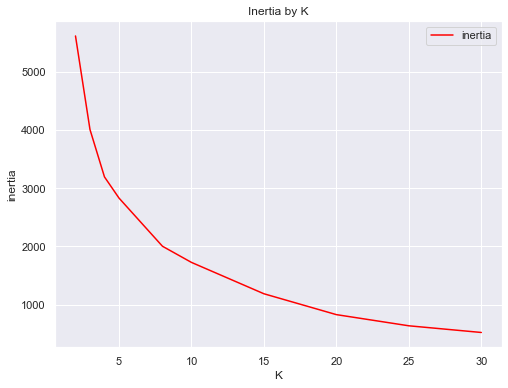

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

### Cluster Analysis

In [92]:
estimator_kmeans = KMeans(random_state=42, n_clusters=8) 
estimator_kmeans.fit(df2_processed)

KMeans(random_state=42)

In [93]:
df2["cluster_id"] = estimator_kmeans.labels_
df2.head()

,country,is_quote,retweet_count,day_post_created,followers_count,friends_count,listed_count,verified,age_of_account,cluster_id
0,France,False,0.0,14.0,406.0,434.0,14,False,2.0,1
1,France,False,0.0,10.0,406.0,434.0,14,False,2.0,1
2,France,False,0.0,13.0,406.0,434.0,14,False,2.0,1
3,France,False,1.0,7.0,406.0,434.0,14,False,2.0,1
4,France,False,1.0,6.0,406.0,434.0,14,False,2.0,1


In [94]:
df2.cluster_id.value_counts()

0    1984
1    1978
2    1443
3    1251
5    1092
4     496
7     357
6     353
Name: cluster_id, dtype: int64

In [95]:
cluster_summary(1, df2)

{'country': 'Canada',
 'is_quote': 'False',
 'verified': 0.0,
 'retweet_count': 1.3882709807886755,
 'day_post_created': 9.67340748230536,
 'followers_count': 8613.605662285136,
 'friends_count': 5671.253286147624,
 'listed_count': 327.85288169868556,
 'age_of_account': 7.760364004044489,
 'cluster_id': 1.0}

In [96]:
cluster_comparison(0,1,2,3,4,5,6,7)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
country,United States,Canada,Unknown,Unknown,United States,United Kingdom,India,Visayas
is_quote,False,False,False,False,False,False,False,False
verified,0.0,0.0,0.008316,0.129496,1.0,0.078755,0.127479,0.005602
retweet_count,1.033266,1.388271,1.379071,1.954436,5.691532,2.063187,1.82153,0.131653
day_post_created,9.370464,9.673407,9.733195,9.573941,9.637097,9.315018,9.560907,10.282913
followers_count,5992.49748,8613.605662,2253.662509,84002.222222,683546.042339,53599.729853,38837.399433,46116.904762
friends_count,1770.372984,5671.253286,809.800416,2952.61231,4869.610887,3133.351648,975.036827,339.62465
listed_count,179.299899,327.852882,38.379764,864.494804,4620.846774,458.019231,85.626062,31.12605
age_of_account,8.179435,7.760364,2.054747,10.477218,10.77621,7.769231,7.308782,8.663866


In [97]:
cluster_results = kmeans_cluster(df2_processed, 10)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [98]:
#cluster_summary2 = cluster_summary2.drop('cluster_id', axis = 1)
cluster_summary2

,age_of_account,country_India,country_United Kingdom,country_United States,country_Unknown,country_Visayas,day_post_created,followers_count,friends_count,is_quote_True,listed_count,retweet_count,verified_True
Cluster,,,,,,,,,,,,,
0,0.545296,0.0,0.000000,1.0,0.000000,0.0,0.421308,0.000120,0.004390,0.047883,0.000856,0.002763,0.000000
1,0.518743,0.0,0.000000,0.0,0.000000,0.0,0.458999,0.000178,0.014673,0.000000,0.001626,0.003225,0.000000
2,0.308395,0.0,0.000000,0.0,1.000000,0.0,0.284436,0.000063,0.003040,0.000000,0.000372,0.003293,0.000000
3,0.487252,1.0,0.000000,0.0,0.000000,0.0,0.445113,0.000778,0.002418,0.067989,0.000409,0.004870,0.127479
4,0.500561,0.0,1.000000,0.0,0.000000,0.0,0.428816,0.000130,0.007994,0.000000,0.001087,0.004979,0.003158
5,0.734690,0.0,0.000000,1.0,0.000000,0.0,0.441497,0.014592,0.008351,0.023256,0.026537,0.017473,1.000000
6,0.577591,0.0,0.000000,0.0,0.000000,1.0,0.535364,0.000924,0.000842,0.008403,0.000149,0.000352,0.005602
7,0.707026,0.0,0.203431,0.0,0.424020,0.0,0.451287,0.011809,0.013883,0.017157,0.017817,0.015650,1.000000
8,0.475571,0.0,0.000000,0.0,1.000000,0.0,0.743827,0.000078,0.005919,0.000000,0.000745,0.002737,0.000000


<AxesSubplot:xlabel='Cluster'>

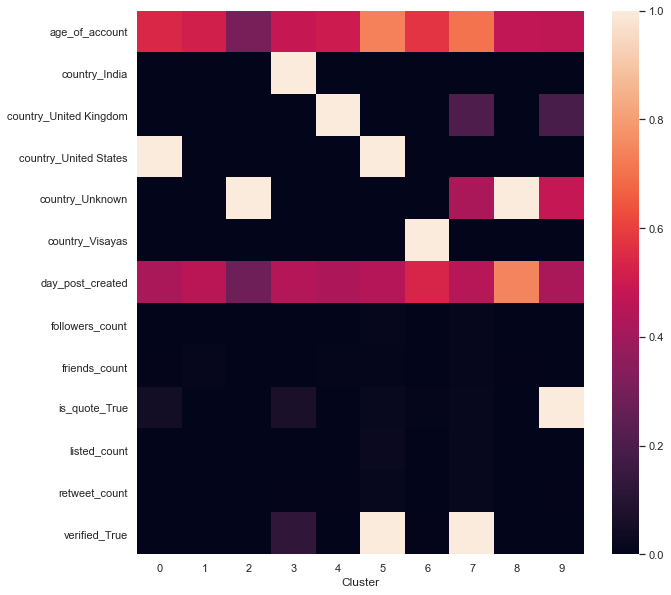

In [99]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False)
# the cluster looks better than the previous one on only the tweets